### This code attempts to use the Navier - Stokes equation to inpaint the image
Code uses the method of Streamfunction-Vorticity Formulation to solve:
* https://www.iist.ac.in/sites/default/files/people/psi-omega.pdf
* http://elynxsdk.free.fr/ext-docs/Inpainting/todo/inpainting%20with%20the%20Navier-Stokes%20Equations.pdf

In [2]:
# %matplotlib widget #If viewed in Jupyter lab
# calling it a second time may prevent some graphics errors
%matplotlib notebook

from PIL import Image
import numpy as np
import sys
from matplotlib import pyplot as plt
# For printing out all the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Upload an image, the mask, convert to grayscale and demage the image

In [7]:
img = Image.open('Pics\serveimage.jpg', mode='r').convert('L')
Mask = Image.open('Pics\TheMask.png', mode='r').convert('L')
#Mask = Image.open('Pics\TheMaskEasy.png', mode='r').convert('L')

I = np.asarray(img).copy()  # Copy so that you can update the file
MaskMat = np.asarray(Mask).copy()

MaskMat[MaskMat < 128] = 0    # Black
MaskMat[MaskMat >= 128] = 255  # White
IDem = I.copy()

IDem[IDem==0] = 1
IDem[MaskMat == 0] = 0


### Define the positions of the demaged regions and boundary conditions
* We find the outer border of the demage and define the boundary values "bc" to have the value 0 everywhere excpet on the boundary, where it has the value of the previous picture

In [9]:
from PIL import ImageFilter
import PIL.ImageOps

# This gives the outer border - where we can take the border conditions
borderInv1 = PIL.ImageOps.invert(Mask).filter(ImageFilter.CONTOUR)
borderInv = np.asarray(borderInv1)

bc = np.zeros([len(I), len(I[1])])
bc[borderInv != 255] = IDem[borderInv != 255]
bc[:, [0, -1]] = 0  # Otherwise there are problems at the border of the image
bc[[0, -1], :] = 0
borderMean=np.mean(bc[borderInv == 0])


#####Uncomment to plot############3
# fig, (ax1, ax2) = plt.subplots(1, 2)
# fig.set_size_inches(10.3, 6.8)
# ax1.imshow(IDem, cmap='gray', interpolation='nearest')
# ax2.imshow(bc, cmap='gray')

* Pts0 - Initial values of I inside the the damaged region. Itherwise the values = -1
* IBound - The Intensity boundary values. We will take out some of the values where, v and u are hard to calculate

In [10]:
Pts0 = np.array([[-1]*len(I[0])]*len(I))
Pts0[IDem == 0] = borderMean

IBound = IDem.copy()  #The matrix of I values outside damage

We will need to calculate the derivatives outside the damaged region. First $\omega = \Delta \times v$, but then $v = \Delta^\perp I = v$, so we will need kind of second derivative of I. This is why we need either central difference or one-sidedm using 3 I values. We need to check if there are enough boundary values to numerically calculate the derivative.

* Check Matrices for each coordinate give:
1. <0 if the point is inside the boundary
2. *>=* the number of neighbours which are in the damaged region from the point (0,1,2 or CheckUp; 0... 4 for CheckUp5) 

In [14]:
#The one bellow chacks how many damaged pixels are next to the pixel
CheckBound = MaskMat+1 
CheckUp = CheckBound[:-2,1:-1] + CheckBound[2:,1:-1] - 3*(CheckBound[1:-1,1:-1])
CheckUp = np.pad(CheckUp,(1,1),'constant')
CheckSide=CheckBound[1:-1,2:] + CheckBound[1:-1,:-2] - 3*(CheckBound[1:-1,1:-1])
CheckSide = np.pad(CheckSide,(1,1),'constant')

#How many damaged pixels are in the distance of 2
CheckUp5=CheckBound[4:,2:-2] + CheckBound[:-4,2:-2] + CheckBound[1:-3,2:-2] + CheckBound[3:-1,2:-2] - 5*(MaskMat[2:-2,2:-2]+1)
CheckUp5 = np.pad(CheckUp5,(2,2),'constant')
CheckSide5=CheckBound[2:-2,4:] + CheckBound[2:-2,:-4] + CheckBound[2:-2,1:-3] + CheckBound[2:-2,3:-1] - 5*(MaskMat[2:-2,2:-2]+1)
CheckSide5 = np.pad(CheckSide5,(2,2),'constant')

# CheckUp=0 - we can use center diference, CheckUp==1 & CheckUp5<5 - we can use one sided.

#The only cases when it makes sence to calculate b.c
#Either when it is possible to calculate the central difference CheckUp/CheckDown == 2 or when it is possible to 
#calculate the one-sides dif ((CheckUp==1) &(CheckUp5<3) ). And for both direction it should be possible simultaneously
Cond = ((CheckUp == 0) | ((CheckUp==1) &(CheckUp5<3) ) ) & ( ( (CheckSide==1) &(CheckSide5<3) | (CheckSide == 0) ) )  
Pts0[~Cond] = borderMean





CalculateB - A matrix which will determine if to calculate the boundary conditions
* if = 0 then do not calculate
* if = 1 then calculate

In [15]:
CalculateB = np.array([[0]*len(I[0])]*len(I))
Mmin=np.min(np.where(IDem == 0),axis=1)-3
Mmax=np.max(np.where(IDem == 0),axis=1)+4
CalculateB[Mmin[0]:Mmax[0],Mmin[1]:Mmax[1]] = 1
CalculateB[Pts0==np.floor(borderMean)] = 0

#CalculateB[CheckUp == 1] = 2 #later when calculating boundary conditions this will meet not to take the central difference
#CalculateB[CheckSide == 1] = 3
#CalculateB[(CheckUp == 0) & (Checksides == 0)] = 2 #The easiest case, we can calculate the center difference on both

u = np.array([[0]*len(I[0])]*len(I))
v = np.array([[0]*len(I[0])]*len(I))


Calculate Boundary conditions on velocity (u,v)

In [16]:
IDem=IDem.astype(int)

for y, row in enumerate(CalculateB):
    for x, Val in enumerate(row):
        if Val == 0:
            continue
        if (CheckUp[y,x] == 0): #We can calculate the central dif
            u[y,x] = -(IDem[y+1,x]-IDem[y-1,x])/2
        elif ((CheckUp[y,x]==1) &(CheckUp5[y,x]<3) ): #We can calc the one sides dif
            if IDem[y+2,x] != 0:
                u[y,x] = -(-IDem[y+2,x] + 4*IDem[y+1,x] - 3*IDem[y,x])/2/2
            else:
                u[y,x] = -(3*IDem[y,x] -4*IDem[y-1,x] + IDem[y-2,x])/2/2
        
        if (CheckSide[y,x] == 0):
            v[y,x] = (IDem[y,x+1]-IDem[y,x-1])/2
        elif ((CheckSide[y,x]==1) &(CheckSide5[y,x]<3) ):
                if IDem[y,x + 2] != 0:
                    v[y,x] = (-IDem[y,x+2] +4*IDem[y,x+1] - 3*IDem[y,x])/2/2
                else:
                    v[y,x] = (3*IDem[y,x] - 4*IDem[y,x-1] + 3*IDem[y,x-2])/2/2                
        else:
            print("There is another case, coord x,y = ", x, y)


Derivatives of the velocity

In [17]:
uy = np.array([[0.1]*len(I[0])]*len(I))
vx = np.array([[0.1]*len(I[0])]*len(I))

for y, row in enumerate(bc):
    for x, Val in enumerate(row):
        if Val==0:
            continue
        if (CheckUp[y,x] == 0):
            if CalculateB[y-1,x] == 0:
                if (CheckUp5[y,x] == 1) or (CheckUp5[y,x] == 0) :   #This actually does not solve all of the problems, but I am tired
                    uy[y,x] = (-u[y+2,x] +4*u[y+1,x] - 3*u[y,x])/2/2
                else:
                    uy[y,x] = np.nan  #kind of nan but np.nan does not work
            elif CalculateB[y+1,x] == 0:
                if (CheckUp5[y,x] == 1) or (CheckUp5[y,x] == 0) :
                    uy[y,x] = (+u[y-2,x] - 4*u[y-1,x] + 3*u[y,x])/2/2
                else:
                    uy[y,x] = np.nan #kind of nan but np.nan does not work
            else:
                uy[y,x] = -(u[y+1,x]-u[y-1,x])/2
        elif ((CheckUp[y,x]==1) &(CheckUp5[y,x]<3) ): #There also could be problems..
            if IDem[y+2,x] != 0:
                uy[y,x] = (-u[y+2,x] +4*u[y+1,x] - 3*u[y,x])/2/2
            else:
                uy[y,x] = (+u[y-2,x] - 4*u[y-1,x] + 3*u[y,x])/2/2
                
        if (CheckSide[y,x] == 0):
            if CalculateB[y,x-1] == 0:
                if (CheckSide5[y,x] == 1) or (CheckSide5[y,x] == 0) :   #This actually does not solve all of the problems, but I am tired
                    vx[y,x] = (-v[y,x+2] +4*v[y,x+1] - 3*v[y,x])/2/2
                else:
                    vx[y,x] = np.nan  #kind of nan but np.nan does not work
            elif CalculateB[y,x+1] == 0:
                if (CheckSide5[y,x] == 1) or (CheckSide5[y,x] == 0) :
                    vx[y,x] = (+v[y,x-1] - 4*v[y,x-1] + 3*v[y,x])/2/2
                else:
                    vx[y,x] = np.nan #kind of nan but np.nan does not work
            else:
                vx[y,x] = -(u[y,x+1]-u[y,x-1])/2
        elif ((CheckSide[y,x]==1) &(CheckSide5[y,x]<3) ): #There also could be problems..
            if IDem[y,x+2] != 0:
                vx[y,x] = (-v[y,x+2] +4*v[y,x+1] - 3*v[y,x])/2/2
            else:
                vx[y,x] = (+v[y,x-2] - 4*v[y,x-1] + 3*v[y,x])/2/2
                

#### Some fast and bad averaging of the nan values. No worries of the error message. If there is an error, that means that everything is great

In [18]:

np.nanmean(vx[np.where(np.isnan(uy))])
np.where(np.isnan(uy))
Wnan=np.where(np.isnan(uy))
for coord in np.transpose(Wnan):
    x=coord[1]
    y=coord[0]
    uy[y,x] = np.nanmean(uy[y-3:y+3,x-3:x+3])

Wnan=np.where(np.isnan(vx))
for coord in np.transpose(Wnan):
    x=coord[1]
    y=coord[0]
    vx[y,x] = np.nanmean(vx[y-3:y+3,x-3:x+3])

np.sum(np.isnan(vx))

0.36428571428571427

(array([ 60,  72,  73,  73,  75,  76,  85, 157, 157, 161, 168, 169, 172,
        172, 172], dtype=int64),
 array([ 64,  89,  80, 311, 304, 279, 100,  72, 362,  48, 231, 115, 138,
        139, 352], dtype=int64))

0

#### The values of w on the Bounary

In [21]:
wBound = (-uy + vx)

#### Plot Boundary conditions on velocities

<IPython.core.display.Javascript object>


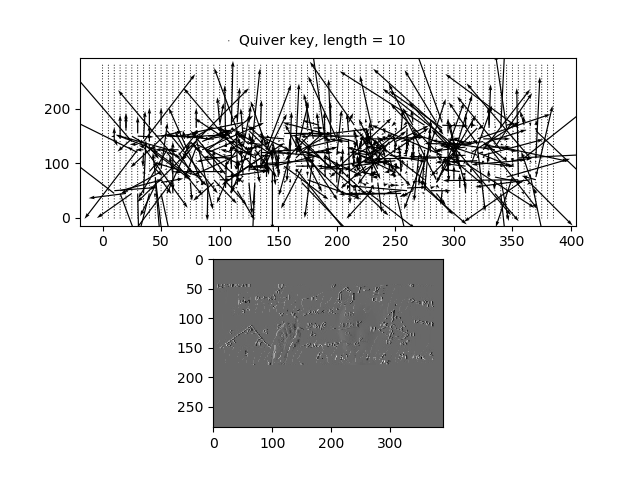

In [22]:
X = np.arange(0, len(I[0]), 5)
Y = np.arange(0, len(I), 5)
U, V = np.meshgrid(X, Y)

fig4, (ax5, ax6) = plt.subplots(2, 1)
q = ax5.quiver(X, Y, u[::5,::5], v[::5,::5])
ax5.quiverkey(q, X=0.3, Y=1.1, U=1,
             label='Quiver key, length = 10', labelpos='E')
#ax5.imshow(I,cmap='gray')
ax6.imshow(v, cmap='gray')

### Start the real Navier-Stokes calculation

In [26]:
NIter = 350
tend=0.00001
dt=tend/NIter

wIn = np.array([wBound]*NIter  * 5) # Inner points at any time
uIn = np.array([u]*NIter)
vIn = np.array([v]*NIter)
InnerPts = np.array([IDem]*NIter) 


w0= wBound.copy()
u0 = u.copy()
v0 = v.copy()

w0[Pts0==np.floor(borderMean)] = np.mean(wBound[borderInv == 0])
u0[Pts0==np.floor(borderMean)] = np.mean(u[borderInv == 0])
v0[Pts0==np.floor(borderMean)] = np.mean(v[borderInv == 0])

wIn = np.append([w0], wIn, axis=0).astype(np.float64)
uIn = np.append([u0], uIn, axis=0).astype(np.float64)
vIn = np.append([v0], vIn, axis=0).astype(np.float64)


InnerPts = np.append([Pts0], InnerPts, axis=0).astype(np.float64)

IfSkip = np.array([[0]*len(I[0])]*len(I))
IfSkip[Pts0 == -1] = 1


# fig4, (ax5) = plt.subplots(1, 1)
# ax5.imshow(wBound, cmap='gray')
#ax6.imshow(CheckSide, cmap='gray')
# InitVal
#ax1.imshow(Pts0, cmap='gray')
#InnerPts = np.append([Pts0], InnerPts, axis=0)


### Navier-Stokes solver
I am doing the usual diffusion, not with an anisothropic diffusion coefficient

In [27]:
N2d = 4
NB = 0  # Nr of vonNeuman boundaries
nu = 0.5 #Viscosity
# AdvectionM = np.array([[-0.1]*len(I[0])]*len(I))
# DiffusionM = np.array([[-0.1]*len(I[0])]*len(I))

def Transport(t, y, x, t5, *args):
    uij = uIn[t,y,x]
    vij = vIn[t,y,x]
        
    Sum = wIn[t5, y-1, x] + wIn[t5, y+1, x] + wIn[t5, y, x-1] + wIn[t5, y, x+1]
    Advection = -uij*(wIn[t5, y, x+1]-wIn[t5,y,x-1])/2 - vij*(wIn[t5, y+1, x]-wIn[t5,y-1,x])/2 
    #Advection = - uij*(wConvx - wIn[t5,y, x] ) - vij*(wConvy - wIn[t5,y, x] )
    Diffusion =  (Sum - (N2d-NB)* wIn[t,y,x] )  # +rho=0
#     AdvectionM[y,x] = Advection
#     DiffusionM[y,x] = Diffusion
    wIn[t5+1,y,x] = wIn[t5,y,x] + dt *(Advection+ nu*Diffusion)
    


Solve the Puasont equation using Jacoby method and then recalculate the velocity (u,v)

In [28]:
def Puasont(t,y,x, *args):
    INeigh = [InnerPts[t, y-1, x], InnerPts[t, y+1, x],InnerPts[t, y, x-1], InnerPts[t, y, x+1]]
    InnerPts[t+1, y, x] = 1/(N2d-NB)*(sum(INeigh) - wIn[t+1,y,x])
    #     Indx = np.array([[y-1, x], [y+1, x], [y, x-1], [y, x+1]])
#     INeigh = InnerPts[t, Indx[:, 0], Indx[:, 1]]
#     for i, indc in enumerate(Indx):
#         if bc[indc[0], indc[1]] != 0:
#             INeigh[i] = bc[indc[0], indc[1]]
#         print(bc[indc[0],indc[1]])
    # print(N2d,NB,sum(uNeigh))

    
def RecalcV(t,j,i, *args):
    uIn [t+1, y, x] = -(InnerPts[t+1,y+1,x] - InnerPts[t+1,y-1,x])/2
    vIn [t+1, y, x] = (InnerPts[t+1,y,x+1] - InnerPts[t+1,y,x-1])/2
#I do not get why working the way it is bellow is 4 times slower...
#     Indx = np.array([[y-1, x], [y+1, x], [y, x-1], [y, x+1]]) 
#     INeigh = InnerPts[t+1, Indx[:, 0], Indx[:, 1]]
#     uIn [t+1, y, x] = -(INeigh[0]-INeigh[1])/2
#     vIn [t+1, y, x] = -(INeigh[2]-INeigh[3])/2

Solving takes 2 minutes for 300 iterations

In [33]:
%%time
for t in range(NIter):
    # -1 because otherwise there are errors in when looking at the postition to the right.
    # There are anyway no changes at the right border
    for y in range(len(InnerPts[0])-1):   
        for x in range(len(InnerPts[0][0])-1):
            if IfSkip[y,x]: #Then neither in the damaged region, nor in the region where it was not possible to calc. bc
                continue
#             for i in range(5):
#             t5=5*t+i
            t5=t
            Transport(t, y, x, t5)
            Puasont(t, y, x)
            RecalcV(t, y, x)                 

Wall time: 2min 30s


#### Plots of pictures at different time steps

<IPython.core.display.Javascript object>


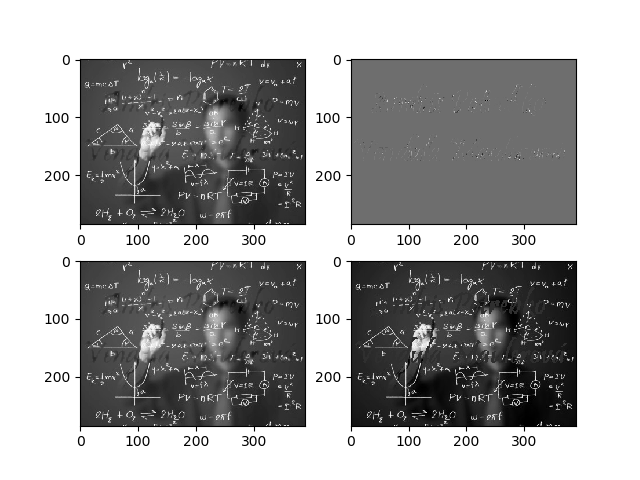

In [34]:
fig2, ((ax3, ax4), (ax5, ax6)) = plt.subplots(2,2)
tPlot=NIter
IRes=IDem.copy()
IRes[MaskMat == 0] = InnerPts[tPlot][MaskMat == 0]
# IRes[IRes < 0] = 80
# IRes[IRes > 255] = 80
ax3.imshow(IRes, cmap='gray', interpolation='nearest')

tPlot=NIter-10
IRes=IDem.copy()
IRes[MaskMat == 0] = InnerPts[tPlot][MaskMat == 0]
# IRes[IRes < 0] = 80
# IRes[IRes > 255] = 80
ax4.imshow(IRes, cmap='gray', interpolation='nearest')

tPlot=NIter-50
IRes=IDem.copy()
IRes[MaskMat == 0] = InnerPts[tPlot][MaskMat == 0]
# IRes[IRes < 0] = 80
# IRes[IRes > 255] = 80
ax5.imshow(IRes, cmap='gray', interpolation='nearest')

tPlot=0
IRes[MaskMat == 0] = InnerPts[tPlot][MaskMat == 0]
IRes[IRes < 0] = 80
IRes[IRes > 255] = 80
ax6.imshow(IRes, cmap='gray', interpolation='nearest')
#ax3.imshow(InnerPts[1], cmap='gray', interpolation='nearest')

ax4.imshow(wBound, cmap='gray', interpolation='nearest')

### Bellow just many attempts to debug

In [25]:
# tPlot=NIter
# IRes1=IDem.copy()
# IRes1[MaskMat == 0] = InnerPts[tPlot][MaskMat == 0]

# tPlot=NIter-1
# IRes=IDem.copy()
# IRes[MaskMat == 0] = InnerPts[tPlot][MaskMat == 0]

# InnerPts[99][InnerPts[99]-InnerPts[100]!=0] - InnerPts[100][InnerPts[99]-InnerPts[100]!=0]

# InnerPts[2]

In [30]:
# t = 30
# x= 89
# y = 76
# MaskMat[y,x-1]
# IfSkip[y,x-1]
# t5=t

# uij = uIn[t,y,x]
# vij = vIn[t,y,x]

# Sum = wIn[t5, y-1, x] + wIn[t5, y+1, x] + wIn[t5, y, x-1] + wIn[t5, y, x+1]
# Advection = -uij*(wIn[t5, y, x+1]-wIn[t5,y,x-1])/2 - vij*(wIn[t5, y+1, x]-wIn[t5,y-1,x])/2 
# #Advection = - uij*(wConvx - wIn[t5,y, x] ) - vij*(wConvy - wIn[t5,y, x] )
# Diffusion =  (Sum - (N2d-NB)* wIn[t,y,x] )  # +rho=0

# Advection
# Diffusion*nu
# wIn[t5,y,x] + dt *(Advection+ nu*Diffusion)
# wIn[t5+15,y,x+2]

# i=np.arange(0,50)
# fig5, ax7 = plt.subplots(1,1)
# ax7.plot(wIn[100, y, :])


In [29]:
# y=144
# x=133
# wBound[176,145:155]

# if (CheckUp[y,x] == 0): #We can calculate the central dif
#     -(IDem[y+1,x]-IDem[y-1,x])/2

In [30]:
# if ((CheckUp[y,x]==1) &(CheckUp5[y,x]<3) ): #We can calc the one sides dif
#     if IDem[y+2,x] != 0:
#         -(-IDem[y+2,x] + 4*IDem[y+1,x] - 3*IDem[y,x])/2
#         print("This")
#     else:
#         -(3*IDem[y,x] -4*IDem[y-1,x] + IDem[y-2,x])/2
        
# IDem[y,x+1]
# IDem[y,x-1]

In [31]:
# if (CheckSide[y,x] == 0):
#     (IDem[y,x+1]-IDem[y,x-1])/2
#     print("This")
# elif ((CheckSide[y,x]==1) &(CheckSide5[y,x]<3) ):
#         if IDem[y,x + 2] != 0:
#             (IDem[y,x+2] +4*IDem[y,x+1] - 3*IDem[y,x])/2
#         else:
#             (3*IDem[y,x] - 4*IDem[y,x-1] + 3*IDem[y,x-2]) 
#             print("This2")

In [32]:
# if (CheckUp[y,x] == 0):
#     if CalculateB[y-1,x] == 0:
#         if (CheckUp5[y,x] == 1) or (CheckUp5[y,x] == 0) :   #This actually does not solve all of the problems, but I am tired
#             (-u[y+2,x] +4*u[y+1,x] - 3*u[y,x])/2
#         else:
#             np.nan  #kind of nan but np.nan does not work
#     elif CalculateB[y+1,x] == 0:
#         if (CheckUp5[y,x] == 1) or (CheckUp5[y,x] == 0) :
#             (+u[y-2,x] - 4*u[y-1,x] + 3*u[y,x])/2
#         else:
#             np.nan #kind of nan but np.nan does not work
#     else:
#         -(u[y+1,x]-u[y-1,x])/2
#         print("FineStuff")
# elif ((CheckUp[y,x]==1) &(CheckUp5[y,x]<3) ): #There also could be problems..
#     if IDem[y+2,x] != 0:
#         (-u[y+2,x] +4*u[y+1,x] - 3*u[y,x])/2
#     else:
#         (+u[y-2,x] - 4*u[y-1,x] + 3*u[y,x])/2

In [33]:
# if (CheckSide[y,x] == 0):
#     if CalculateB[y,x-1] == 0:
#         if (CheckSide5[y,x] == 1) or (CheckSide5[y,x] == 0) :   #This actually does not solve all of the problems, but I am tired
#             (-v[y,x+2] +4*v[y,x+1] - 3*v[y,x])/2
#         else:
#             np.nan  #kind of nan but np.nan does not work
#     elif CalculateB[y,x+1] == 0:
#         if (CheckSide5[y,x] == 1) or (CheckSide5[y,x] == 0) :
#             (+v[y,x-1] - 4*v[y,x-1] + 3*v[y,x])/2
#         else:
#             np.nan #kind of nan but np.nan does not work
#     else:
#         -(u[y,x+1]-u[y,x-1])/2
# elif ((CheckSide[y,x]==1) &(CheckSide5[y,x]<3) ): #There also could be problems..
#     if IDem[y,x+2] != 0:
#         (-v[y,x+2] +4*v[y,x+1] - 3*v[y,x])/2
#     else:
#         print("ThisOne")
#         (+v[y,x-2] - 4*v[y,x-1] + 3*v[y,x])/2